In [3]:
!nvidia-smi

Mon Oct 23 20:42:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P5              13W /  60W |     46MiB /  6144MiB |     29%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#%%capture
#%pip install -U torch torchvision torchdata
#%pip install -U lightning
#%pip install wandb
#%pip install python-dotenv

In [5]:
import os

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
import torchmetrics

import torchdata.datapipes as dp
from torch.utils.data import DataLoader
torchvision.disable_beta_transforms_warning();

from torchvision.models import AlexNet 
import torchvision.transforms.v2 as t

from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import wandb

from tqdm import tqdm
from typing import Callable
from dotenv import load_dotenv
load_dotenv();

from hyperparameters import Hyperparameters
from datamodules import ImagenetteDataModule

import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.WARNING)

os.environ["WANDB_NOTEBOOK_NAME"] = (Path.cwd() / "experiments.ipynb").as_posix()

In [6]:
IMAGENETTE = Path.home() / "datasets" / "imagenette"

CHECKPOINTS_DIR = Path.cwd() / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

LOGS_DIR = Path.cwd() / "logs"
LOGS_DIR.mkdir(exist_ok=True)

In [7]:
class ClassificationModel(LightningModule):
    def __init__(self, model, params: Hyperparameters):
        super().__init__()
        self.model = model

        #TODO : Add dicts for Metrics, Optimizers, Criterions
        self.task = params.task
        self.num_classes = params.num_classes
        self.criterion = params.criterion
        self.optimizer = params.optimizer
        self.learning_rate = params.learning_rate
        self.momentum = params.momentum
        self.weight_decay = params.weight_decay

        self._set_metrics()
        self.save_hyperparameters(
            {i:params.get_litmodule_hparams()[i] 
             for i in params.get_litmodule_hparams().keys() if i!='criterion'},
            ignore = ["model", "params"]
        ) 

    def forward(self, batch):
        x, _ = batch
        return self.model(x)

    def _forward_pass(self, batch, metrics : Callable | None = None) -> tuple:
        x, y = batch
        y_pred = self.model(x)
        if metrics:
            metrics.update(y_pred, y) 
        return self.criterion(y_pred, y), y_pred #type: ignore

    def _set_metrics(self):
        metrics = {"accuracy": torchmetrics.Accuracy(
                                task="multiclass",
                                num_classes=self.num_classes, 
                                average="macro"),

                   "f1" : torchmetrics.F1Score(
                                task="multiclass",
                                num_classes=self.num_classes,
                                average="macro")
                  }

        self.val_metrics = torchmetrics.MetricCollection(
            metrics=metrics, prefix = "val_"
        )
        self.test_metrics = torchmetrics.MetricCollection(
            metrics=metrics, prefix = "test_"
        )
        self.test_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.num_classes,
        )

    def training_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch, self.val_metrics)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        _, y = batch
        _, y_pred = self._forward_pass(batch)
        self.test_metrics.update(y_pred, y)
        self.test_confm.update(y_pred, y)
    
    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

        self.test_confm.compute()
        self.test_confm.plot()
        plt.show()
        self.test_confm.reset()

    def configure_optimizers(self):
        return self.optimizer(params = self.model.parameters(),
                              lr = self.learning_rate,
                              momentum = self.momentum, 
                              weight_decay = self.weight_decay)

In [8]:
experiment = Hyperparameters(
    task = "multiclass_classification",
    random_seed = 42,
    num_classes = 10,
    metrics = ["accuracy", "f1"],

    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    learning_rate = 1e-2,
    momentum = 0,
    weight_decay = 0,

    batch_size = 128,
    grad_accum = 4,
    test_split = .3,
    transform = ["scale_[0,1]", "resize_256", "random_crop_224", "normalize"],
    num_workers = 8,
)
seed_everything(experiment.random_seed, workers = True);
alexnet = AlexNet(num_classes = experiment.num_classes, dropout= 0.0)
alexnet_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    t.Resize(size = (256, 256), antialias = True),
    t.RandomCrop(size = (224, 224), pad_if_needed = True),
    t.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    #t.RandomHorizontalFlip(p = .5)
])
imagenette_dm = ImagenetteDataModule(
        root = IMAGENETTE, 
        params = experiment, 
        transform = alexnet_transform)

Seed set to 42


In [9]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
local_checkpoint = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="{epoch}-{train_loss:2f}-{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

local_logger = CSVLogger(
    save_dir=Path.cwd(),
    name="logs",
    version=1,
)

wandb.finish()
wandb_logger = WandbLogger(
    save_dir=LOGS_DIR,
    project="ilsvrc",
    log_model=True,
    name="test"
    #version='1',
)

In [14]:
trainer = Trainer(
    #fast_dev_run=True,
    #num_sanity_val_steps=10,
    #limit_predict_batches=20,
    #deterministic=True,
    #benchmark=True,
    #enable_checkpointing=False,
    callbacks=[local_checkpoint],
    logger=[local_logger, wandb_logger],

    max_epochs = 20,
    accumulate_grad_batches = experiment.grad_accum,
    check_val_every_n_epoch = 5
)

last_ckpt = CHECKPOINTS_DIR / "last.ckpt"
last_ckpt = last_ckpt if last_ckpt.is_file() else None

In [15]:
trainer.fit(
    model=ClassificationModel(alexnet, experiment),
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt #type: ignore
)

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sambhav/dev/ilsvrc/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

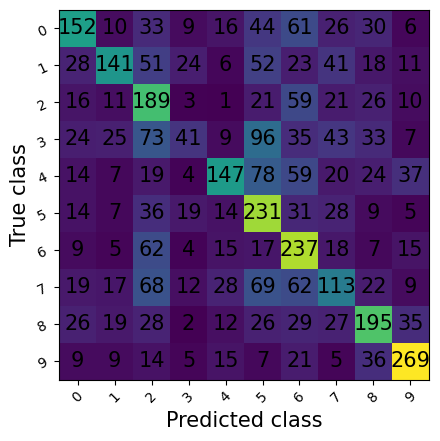

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4388473629951477     │
│          test_f1          │    0.42573338747024536    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.4388473629951477, 'test_f1': 0.42573338747024536}]

In [16]:
trainer.test(
    model=ClassificationModel(alexnet, experiment),
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt,
)